In [8]:
#pip install pydotplus
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer
from skompiler import skompile
import graphviz

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [13]:
warnings.simplefilter(action='ignore', category=Warning)
df = pd.read_csv("diabetes.csv")

In [14]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [18]:
#FUNCTIONS

In [19]:
def outlier_thresholds(dataframe ,col ,q1=.05 , q3=.95, decimal=3):
    quartile1=dataframe[col].quantile(q1)
    quartile3=dataframe[col].quantile(q3)
    iqr=quartile3-quartile1
    low_limit= round(quartile1 - (iqr*1.5) , decimal)
    up_limit= round(quartile3 + (iqr*1.5), decimal)
    return low_limit , up_limit



def replace_with_thresholds(dataframe, col_name, q1=.05, q3=.95, lower_limit = None, upper_limit = None):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if lower_limit != None:
        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
    else:
        dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit

    if upper_limit != None:
        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
    else:
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit




def plot_importance(model, features, num:int = 0, save=False):
    if num <= 0:
        num = X.shape[1]
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')




def val_curve_params(model, X, y, param_name, param_range, scoring="accuracy", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)




def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)



In [20]:
# DATA PREPROCESSING
###########################################

#Replacing outliers with these values.
cols = [col for col in df.columns if col != "Outcome"]
for col in cols:
    replace_with_thresholds(df, col)



#Columns that cannot contain zero
problematic_cols = [col for col in df.columns if col not in ["Pregnancies",'DiabetesPedigreeFunction','Outcome']]


#Now replace these zeros with NaN
for col in problematic_cols:
    df[col]=df[col].replace(0,np.nan)


# Filling NaN values by using KNN Imputer
scaler=MinMaxScaler()
df=pd.DataFrame(scaler.fit_transform(df), columns=df.columns) 
imputer=KNNImputer(n_neighbors=5)
df=pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df=pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)



In [21]:
# FEATURE ENGINEERING
##################################################



df.loc[(df["Age"] <= 18 ), "NEW_AGE"] = "young"
df.loc[(df["Age"] > 18 ) & (df["Age"] <= 24), "NEW_AGE"] = "adult"
df.loc[(df["Age"] > 24 ) & (df["Age"] <= 59), "NEW_AGE"] = "mid_adult"
df.loc[(df["Age"] > 59), "NEW_AGE"] = "senior"



df.loc[(df["BMI"] < 18.5) , "BMI_CAT"] ="underweight"
df.loc[(df["BMI"] >= 18.5) & (df["BMI"] < 24.9) , "BMI_CAT"] ="normal"
df.loc[(df["BMI"] >= 24.9) & (df["BMI"] < 29.9) , "BMI_CAT"]="overweight"
df.loc[(df["BMI"] >= 29.9) , "BMI_CAT"] ="obese"



df.loc[(df["Insulin"] < 15) , "INSULIN_CAT"] ="low"
df.loc[(df["Insulin"] >= 15) & (df["Insulin"] < 166) , "INSULIN_CAT"] ="normal"
df.loc[(df["Insulin"] >= 166) , "INSULIN_CAT"] ="high"


# One Hot Encoding
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df= pd.get_dummies(df,columns= ohe_cols, drop_first=True)


X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]

In [22]:
def feature_selecter(input_x, y, candidate_features_dict:dict, candidate_features_id:list, best_features:list, best_accuracy=0, verbose=True):
    if not candidate_features_id:
        return best_accuracy, best_features
    best_x = input_x   
    best_feature= -1 
    if best_accuracy == 0:
        cart_model = DecisionTreeClassifier(random_state=17).fit(input_x, y)
        
        cv_results = cross_validate(cart_model,
                                    input_x, y,
                                    cv=5,
                                    scoring="accuracy")

        best_accuracy = cv_results["test_score"].mean()

    if verbose:
       print(f"best accuracy(old) = {best_accuracy}")
       #print(candidate_features_id) 
 
    for feature in candidate_features_id:       
            X = input_x.copy(deep=True)

            # define your candidate feature here!
            if feature == 0:
                X[candidate_features_dict[feature]] = X["Insulin"]*X["Glucose"]

            elif feature == 1:
                X[candidate_features_dict[feature]] = X["Glucose"]/(X["Insulin"]+0.0001)

            elif feature == 2:
                X[candidate_features_dict[feature]] = X["Age"]*X["Pregnancies"]

            elif feature == 3:
                X[candidate_features_dict[feature]] = X["Age"]/(X["Pregnancies"]+0.0001)

            elif feature == 4:
                X[candidate_features_dict[feature]] = X["Age"]*X["Pregnancies"]*X["Glucose"]

            elif feature == 5:
                X[candidate_features_dict[feature]] = X["Glucose"]/(X["Age"]+0.0001)

            elif feature == 6:
                X[candidate_features_dict[feature]] = X["Insulin"]/(X["Age"]+0.0001)

            elif feature == 7:
                X[candidate_features_dict[feature]] = X["BMI"]*X["Pregnancies"]

            elif feature == 8:
                X[candidate_features_dict[feature]] = X["BMI"]*X["Age"]

            elif feature == 9:
                X[candidate_features_dict[feature]] =  X["BMI"]*(X["Age"])*X["Pregnancies"]

            elif feature == 10:
                X[candidate_features_dict[feature]] = X["BMI"]*(X["Glucose"])

            elif feature == 11:
                X[candidate_features_dict[feature]] = X["DiabetesPedigreeFunction"]*(X["Insulin"])

            elif feature == 12:
                X[candidate_features_dict[feature]] = X["SkinThickness"]*(X["Insulin"])

            elif feature == 13:
                X[candidate_features_dict[feature]] = X["Pregnancies"]/(X["Age"]+0.0001)
            
            elif feature == 14:
                X[candidate_features_dict[feature]] = X["Glucose"]+X["Insulin"]+X["SkinThickness"]
            
            elif feature == 15:
                X[candidate_features_dict[feature]] = X["BloodPressure"]/(X["Glucose"]+0.0001)

            
            
            cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)
            
            cv_results = cross_validate(cart_model,
                                        X, y,
                                        cv=5,
                                        scoring="accuracy")
        
            accuracy = cv_results["test_score"].mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
                best_x = X

    if best_feature == -1: 
        return best_accuracy, best_features 
    
    best_features.append(best_feature)
    candidate_features_id.remove(best_feature)

    if verbose:
       print(f"best accuracy(new) = {best_accuracy}")  
       print(f"added feature  = {best_feature}", end = '\n\n')   
       #print(best_features)
    
    return feature_selecter(best_x, y, candidate_features_dict, candidate_features_id, best_features, best_accuracy, verbose)

In [23]:
candidate_features = {0:"new_glucoseXinsulin",
            1:"new_glucose/insulin",
            2:"new_ageXpreg",
            3:"new_age/preg",
            4:"new_ageXpregXglucose",
            5:"new_glucose/age",
            6:"new_insulin/age",
            7:"new_bmiXpreg",
            8:"new_bmiXage",
            9:"new_bmiXageXpreg",
            10:"new_bmiXglucose",
            11:"new_degreeXinsulin",
            12:"new_skinXinsulin",
            13:"new_preg/age",
            14:"new_glucose+insulin+skin",
            15:"new_blood/glucose"}

accuracy, new_features = feature_selecter(X,y,candidate_features, list(candidate_features.keys()), best_features=[])
'''
best accuracy(old) = 0.7291401409048468
best accuracy(new) = 0.7539003480179951
added feature  = 15

best accuracy(old) = 0.7539003480179951
'''


#See which feature is selected.
for feature in new_features:
    print(candidate_features[feature])
#new_blood/glucose



#Add this newly created feature.
X["new_blood/glucose"] = X["BloodPressure"]/(X["Glucose"]+0.0001) 





best accuracy(old) = 0.7291401409048468
best accuracy(new) = 0.7539003480179951
added feature  = 15

best accuracy(old) = 0.7539003480179951
new_blood/glucose


In [24]:
# MODEL BUILDING AND EVALUATION
##################################################


#Build the CART model.
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)


#Evaluate with 5-Fold CV
cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print(f"Accuracy : {cv_results['test_accuracy'].mean()}")    # 0.7539
print(f"Precision : {cv_results['test_precision'].mean()}")  # 0.6467
print(f"Recall : {cv_results['test_recall'].mean()}")        # 0.6605
print(f"F1 Score : {cv_results['test_f1'].mean()}")          # 0.6515
print(f"ROC AUC : {cv_results['test_roc_auc'].mean()}")      # 0.7322






Accuracy : 0.7539003480179951
Precision : 0.6467582818073466
Recall : 0.6605171208944793
F1 Score : 0.6515245673866363
ROC AUC : 0.7322585604472398


In [25]:
# HYPERPARAMETER OPTIMIZATION
##################################################

#We will use GridSearchCV to find the optimal hyperparameters.
#First, see the current parameters.
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [26]:
#Let's use GridSearchCV for the max_depth and min_samples_split parameters. 
#Initially, max_depth = None and min_samples_split = 2. We will try max_depth 
#from 1 to 10, min_samples_split from 2 to 19 and find the best parameter 
#values ​​that give the highest accuracy

cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True, scoring="accuracy").fit(X, y)

print(cart_best_grid.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 7, 'min_samples_split': 4}


In [27]:
#So it seems when max_depth = 7 and min_samples_split = 4, we obtain the
#highest accuracy. Let's the accuracy after this hyperparameter tuning
print(cart_best_grid.best_score_) 

0.7629403276462099


In [28]:
# FINAL MODEL
################################################

#Build the final model
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)

#See our newly updated parameters, max_depth = 7, min_samples_split = 4
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [29]:
cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print(f"Accuracy : {cv_results['test_accuracy'].mean()}")    
print(f"Precision : {cv_results['test_precision'].mean()}")  
print(f"Recall : {cv_results['test_recall'].mean()}")       
print(f"F1 Score : {cv_results['test_f1'].mean()}")          
print(f"ROC AUC : {cv_results['test_roc_auc'].mean()}")      

Accuracy : 0.7629403276462099
Precision : 0.667487090351823
Recall : 0.6681341719077569
F1 Score : 0.662153161075458
ROC AUC : 0.7667844164919637


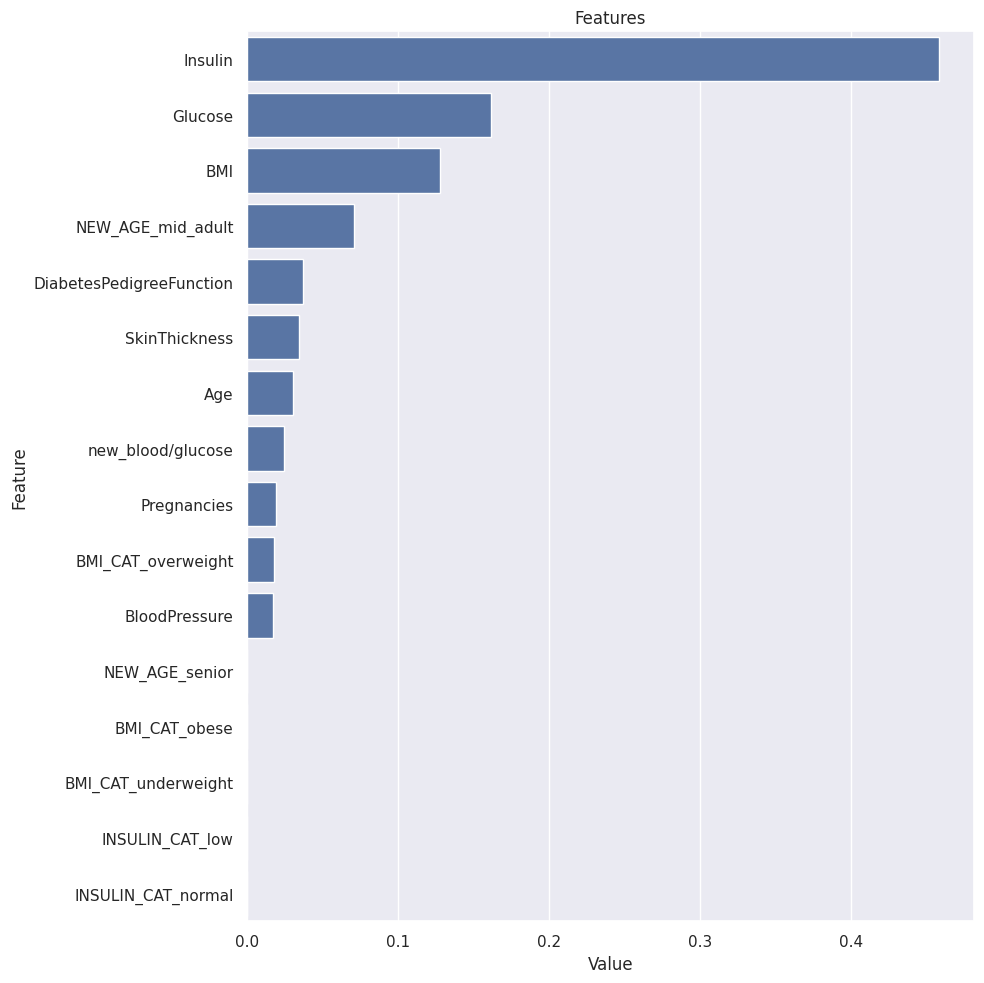

In [30]:
# FEATURE IMPORTANCE
################################################

#See the most important features.
plot_importance(cart_final, X, save=False)

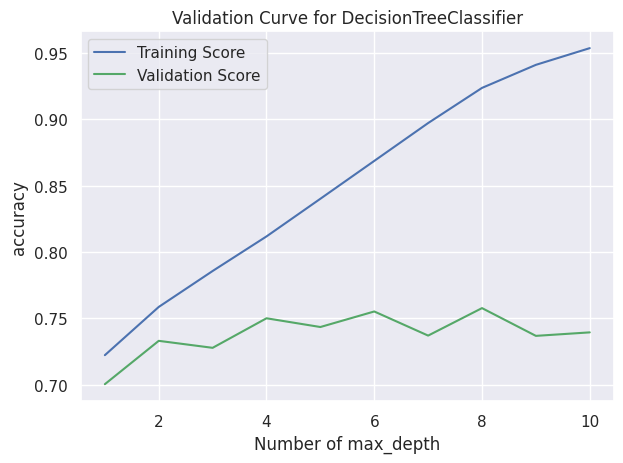

In [31]:
# ANALYZING MODEL COMPLEXITY WITH LEARNING CURVES 
################################################

val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="accuracy")

In [34]:
 #VISUALIZING THE DECISION TREE 
################################################


#We can visualize the decision tree we obtained using the CART algorithm. 
#The tree_graph function will create an image named "cart_final.png" in 
#the directory.
tree_graph(model=cart_final, col_names=X.columns, file_name="cart_final.png")

In [37]:
#We can also express the decision tree in the "cart_final.png" picture above 
#with text or code.

#Text
tree_rules = export_text(cart_final, feature_names=list(X.columns))  
print(tree_rules)

|--- Insulin <= 127.80
|   |--- Glucose <= 123.50
|   |   |--- BMI <= 50.90
|   |   |   |--- Insulin <= 110.10
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.75
|   |   |   |   |   |--- new_blood/glucose <= 0.64
|   |   |   |   |   |   |--- new_blood/glucose <= 0.64
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- new_blood/glucose >  0.64
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- new_blood/glucose >  0.64
|   |   |   |   |   |   |--- Insulin <= 36.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Insulin >  36.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.75
|   |   |   |   |   |--- BMI <= 32.70
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- BMI >  32.70
|   |   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.88
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- DiabetesPedigreeFunction >  0.88
|   |   |   |   |

In [38]:
pip install astor


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
#Python 
print(skompile(cart_final.predict).to('python/code'))


(((((((0 if x[15] <= 0.6409004628658295 else 1) if x[15] <= 
    0.6422942876815796 else 0 if x[4] <= 36.5 else 0) if x[6] <= 
    0.7525000274181366 else 0 if x[5] <= 32.70000076293945 else 1 if x[6] <=
    0.8784999847412109 else 0) if x[4] <= 110.0999984741211 else 1 if x[4] <=
    110.29999923706055 else (0 if x[5] <= 33.849998474121094 else 0) if x[5
    ] <= 45.39999961853027 else 1) if x[5] <= 50.89999961853027 else 1) if 
    x[1] <= 123.5 else 0 if x[5] <= 26.300000190734863 else ((1 if x[5] <= 
    27.65000057220459 else 0 if x[5] <= 36.20000076293945 else 1) if x[15] <=
    0.6183468401432037 else 0) if x[6] <= 0.7114999890327454 else 1) if x[4
    ] <= 127.79999923706055 else (((0 if x[7] <= 69.5 else 0) if x[3] <= 
    25.59999942779541 else ((0 if x[0] <= 7.0 else 1) if x[5] <= 
    42.04999923706055 else 1) if x[4] <= 154.5 else (0 if x[1] <= 127.5 else
    1) if x[4] <= 281.8000030517578 else 0) if x[8] <= 0.5 else 0 if x[5] <=
    26.25 else ((1 if x[0] <= 4.0 else 1) 

In [43]:
#However, we added some new columns during feature engineering. For example 
#NEW_AGE, new_blood/glucose. While we originally had 8 independent columns, 
#now we have 16 independent columns. Therefore, an X value that we enter as 
#input must have these new features. That's why we write a function called 
#converter() and this function converts the original 8 feature sample 
#into 16 features.
def converter(inp):                 
    if inp[7] <= 18:
        inp += [1,1]
    elif (inp[7] > 18) & (inp[7] <= 24):
        inp += [0,0]
    elif (inp[7] > 24) & (inp[7] <= 59):
        inp += [1,0]
    elif inp[7] >= 60:
        inp += [0,1]
    
    if inp[5] < 18.5:
        inp += [0,0,1]
    elif (inp[5] >= 18.5) & (inp[5] < 24.9):
        inp += [0,0,0]
    elif (inp[5] >= 24.9) & (inp[5] < 29.9):
        inp += [0,1,0]
    elif inp[5] >= 29.9:
        inp += [1,0,0]

    if inp[4] < 15:
        inp += [1,0]
    elif (inp[4] >= 15) & (inp[4] < 166):
        inp += [0,1]
    elif inp[4] >= 166:
        inp += [0,0]
    
    inp.append(inp[2]/(inp[1]+0.0001))
    return inp

In [44]:
#Let's make an example.
x = [12, 13, 20, 23, 4, 55, 12, 7]
x = converter(x)
print(x) 

[12, 13, 20, 23, 4, 55, 12, 7, 1, 1, 1, 0, 0, 1, 0, 1.5384497042330443]


In [45]:
# SAVING AND LOADING MODEL
################################################

#Let's say you created a good model and you want to share that model with 
#other people. In this case, you can save the final model as a pkl file and 
#share with other people.
#Save model as pkl file
joblib.dump(cart_final, "cart_final.pkl")



['cart_final.pkl']

In [46]:
#Load model from pkl file
cart_model_from_disc = joblib.load("cart_final.pkl")



#And you can use the model..
x = [12, 13, 20, 23, 4, 55, 12, 7]
x = converter(x)
#since you are using a sklearn model, you also need to convert it pandas df.
x = pd.DataFrame(x).T
print(cart_model_from_disc.predict(x))  # [1.]

[1.]
